In [1]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold
using JLD2
using DataFrames

## Lets load in our H matrix

In [2]:
@load joinpath("data", "logH_matrix_materials_and_gases.jld2") H master_list_of_materials master_list_of_gases MSE
#H = deepcopy(new_H) # log(H)
materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H

nm, ng = size(H) #no. of materials and gases

@assert length(materials) == nm && length(gases) == ng

In [3]:
@printf("Sparsity of H is %.3f%%", sum(ismissing.(H))/length(H))

Sparsity of H is 0.861%

In [4]:
old_H = deepcopy(H)

214×41 Array{Union{Missing, Float64},2}:
 0.70944     missing   missing  -0.224811   …   0.0139194    missing  missing
  missing  -0.72817    missing    missing        missing     missing  missing
  missing    missing   missing  -0.431686        missing     missing  missing
  missing    missing   missing   0.187498        missing     missing  missing
  missing    missing   missing    missing        missing     missing  missing
  missing    missing   missing    missing   …    missing     missing  missing
  missing    missing   missing    missing      -1.16012      missing  missing
  missing    missing   missing    missing        missing     missing  missing
  missing    missing   missing    missing        missing     missing  missing
  missing    missing   missing    missing        missing     missing  missing
  missing    missing   missing    missing   …  -0.687773     missing  missing
 0.570456    missing   missing    missing      -0.794317    0.885583  missing
  missing    missing   

## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [5]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2},
                                       MSE::Array{Union{Float64, Missing}, 2},
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    MSE .= MSE[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    MSE .= MSE[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) <= sum(ismissing.(H[:, 3])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) <= sum(ismissing.(H[3, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, MSE, materials, gases)

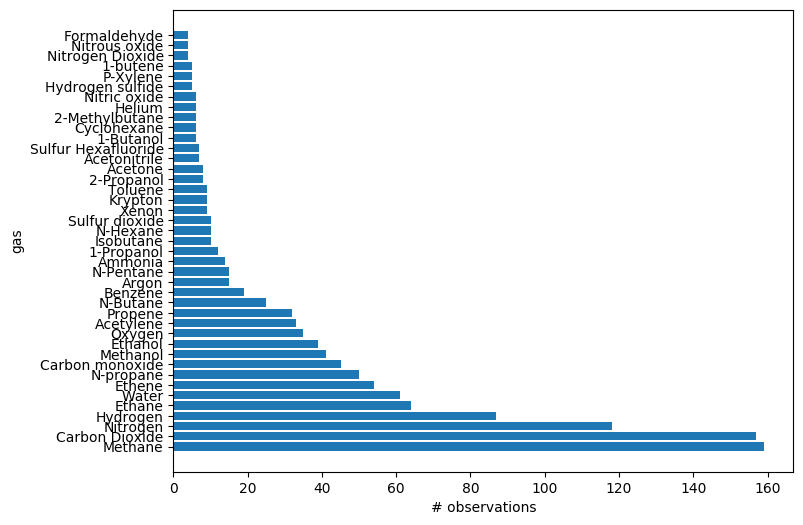

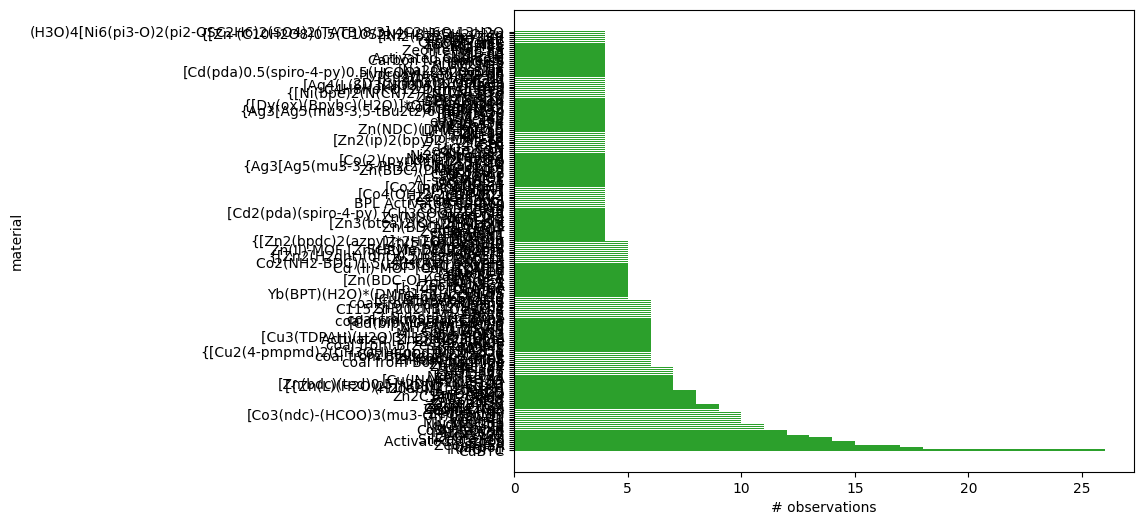

PyObject Text(23.99999999999993, 0.5, 'material')

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
ax.set_xlabel("# observations")
ax.set_ylabel("gas")

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
ax.set_xlabel("# observations")
ax.set_ylabel("material")

## Lets visualize the Henry Coefficient Matrix

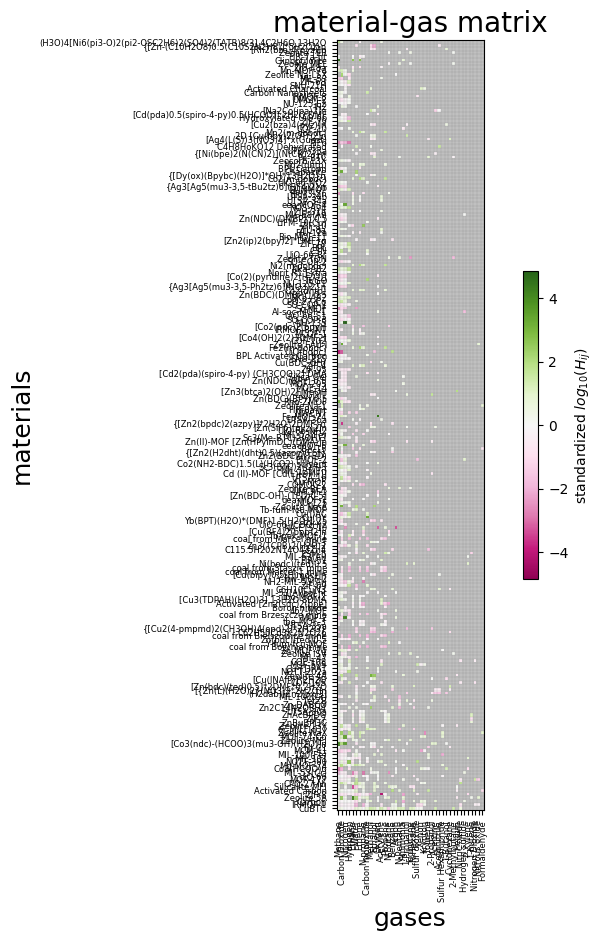

In [7]:
spy_H = deepcopy(H)
spy_H[ismissing.(H)] .= 0.0

spy_H2 = fill(0.0, size(H))
spy_H2[.!ismissing.(H)] .= 0
spy_H2[ismissing.(H)] .= 1

fig, ax = subplots(figsize=(10, 10))
img = ax.pcolormesh(spy_H, cmap="PiYG", 
    vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(img, label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)

#cmap = plt.get_cmap("PiYG")
#colors = cmap(collect(1:cmap.N))
colors = Array{Float64, 2}(undef, 2, 4)
colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
colors[2, :] .= [192., 192., 192., 255.] ./ 255
cmap = matplotlib.colors.ListedColormap(colors)
img = ax.pcolormesh(spy_H2, cmap=cmap)

# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.15, color="gray")
end
for y = 1:ng
    plot([y, y ], [0, nm], linewidth=0.15, color="gray")
end
ax.set_aspect("equal")
ax.set_title("material-gas matrix", fontsize=20)
ax.set_xlabel("gases", fontsize=18)
ax.set_ylabel("materials", fontsize=18)
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90, fontsize=6)
yticks(collect(1:nm) .- 0.5, materials, fontsize=6);
plt.savefig("H_matrix.png", dpi=300, format="png")

## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [8]:
H = collect(H')
MSE = collect(MSE')
H_df = DataFrame(H)

,x1,x2,x3,x4,x5,x6,x7,x8
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0.331856,-0.218552,-0.0764054,0.423264,-0.465031,0.516673,0.415204,0.575601
2,0.40837,-0.343014,-0.121163,2.36603,-0.842364,0.26889,missing,1.66704
3,0.0105201,-0.177502,0.0346012,0.295544,-0.586776,0.0698212,0.0552871,0.809902
4,-0.146066,-0.290649,0.0139194,missing,-0.332019,-0.0563126,missing,-0.267663
5,-0.434583,-0.319508,-0.224811,4.11648,-0.429083,0.178005,-3.29955,0.549278
6,0.741167,-1.7751,-0.963968,1.96844,-1.16331,0.908274,-1.33409,1.72817
7,0.675237,missing,0.374688,-0.344659,-0.899737,missing,0.305163,0.991009
8,0.0935156,-1.77488,missing,0.620477,-0.167093,0.193295,0.480557,0.397442
9,0.671111,-0.168344,0.225739,0.914761,-0.534265,missing,missing,missing


In [9]:
obs = observations(H)
@assert length(obs) == sum(.! ismissing.(H))

In [10]:
obs

1219-element Array{Tuple{Int64,Int64},1}:
 (1, 1)   
 (2, 1)   
 (3, 1)   
 (4, 1)   
 (5, 1)   
 (6, 1)   
 (7, 1)   
 (8, 1)   
 (9, 1)   
 (10, 1)  
 (11, 1)  
 (12, 1)  
 (13, 1)  
 ⋮        
 (10, 212)
 (11, 212)
 (20, 212)
 (31, 212)
 (6, 213) 
 (10, 213)
 (11, 213)
 (29, 213)
 (1, 214) 
 (2, 214) 
 (7, 214) 
 (13, 214)

In [11]:
function k_fold_split(H::Array{Union{Missing, Float64}, 2}, k::Int; max_iter=1000, use_weighted_sampling::Bool=false)
    #@assert k > 1 "Choose a `k` greater than 1, otherwise this function is pointless"
    @printf("Splitting matrix into %d folds\n", k)
    if use_weighted_sampling
        @warn "Warning: You are using weighted sampling. Whether this is applicable in k-fold cross validation is unclear at the moment."
    end
    fold_matrix = fill(0, size(H))
    all_k_folds_not_represented_in_each_column = true
    n_iteration = 0

    while all_k_folds_not_represented_in_each_column
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = false
        for j_col = 1:size(H)[2]
            # Grabs all available indices in row `i_row`
            i_indices = findall(.!ismissing.(H[:,j_col]))
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while length(i_indices) >= k
                for fold = 1:k
                    i = rand(1:length(i_indices))
                    fold_matrix[i_indices[i], j_col] = fold
                    deleteat!(i_indices, i)
                end
            end
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for i in i_indices
                if use_weighted_sampling
                    items = collect(1:k)
                    weights = [sum(fold_matrix[:, j_col] .!= _k .| fold_matrix[:, j_col] .!= 0) for _k = 1:k]
                    fold_matrix[i, j_col] = sample(items, Weights(weights))
                else
                    fold_matrix[i, j_col] = rand(1:k)
                end
            end
        end
        # We make sure we have enough data points in the columns as well
        for i_row = 1:size(H)[1]
            unique_folds = unique(fold_matrix[i_row, :])
            if length(unique_folds) <= k
                all_k_folds_not_represented_in_each_column = true
                break
            end
        end

        # If too many iteration are performed an Exception is raised.
        if n_iteration >= max_iter
            error("Maximum number of iterations reached. Try changing the `max_iter` argument.")
        end
    end
    
    for i = 1:size(H)[1]
        for j = 1:size(H)[2]
            if ismissing(H[i,j])
                continue
            else
                @assert fold_matrix[i,j] != -1 "A non-NaN value was not put in a fold"
            end
        end
    end
    
    @printf("Number of iterations required to split data into %d-folds: %d\n", k, n_iteration)
    for fold = 1:k
        @printf("Number of data points in fold %d: %d\n", fold, sum(fold_matrix .== fold))
    end
    @printf("Total number of data points: %d\n", sum(.!ismissing.(H)))
    @printf("-----------------------------------\n")
    return fold_matrix
end

fold_matrix = k_fold_split(H, 3, max_iter=100000, use_weighted_sampling=true)
temp_fold_matrix = replace(fold_matrix, 0 => missing)
kfolds = [(findall(collect(skipmissing(temp_fold_matrix))[:] .!= k), 
           findall(collect(skipmissing(temp_fold_matrix))[:] .== k)) 
                for k = 1:length(unique(fold_matrix))-1]
n_folds = length(kfolds)

Splitting matrix into 3 folds


┌ Warning: Warning: You are using weighted sampling. Whether this is applicable in k-fold cross validation is unclear at the moment.
└ @ Main In[11]:5


Number of iterations required to split data into 3-folds: 1319
Number of data points in fold 1: 394
Number of data points in fold 2: 422
Number of data points in fold 3: 403
Total number of data points: 1219
-----------------------------------


3

In [12]:
#kfolds = KFold(length(obs), n_folds=length(obs))
#n_folds = length(obs)

In [45]:
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int, Int}, 1})
    loss = QuadLoss()
    #r_m = QuadReg(γ/nm)
    #r_g = QuadReg(γ/ng)
    r_m = ZeroReg()
    r_g = ZeroReg()
    glrm = GLRM(H, loss, r_g, r_m, k, obs=obs, offset=true, sparse_na=false)
    #init_svd!(glrm)
    G, M, ch = fit!(glrm, verbose=false)
    #println("Convergence history: ",ch.objective)
    return M, G, glrm, ch
end
M, G, glrm, ch = fit_glrm(3, 5.5, obs);

## How does the model deal with training on the whole data set (and overfitting as a result)

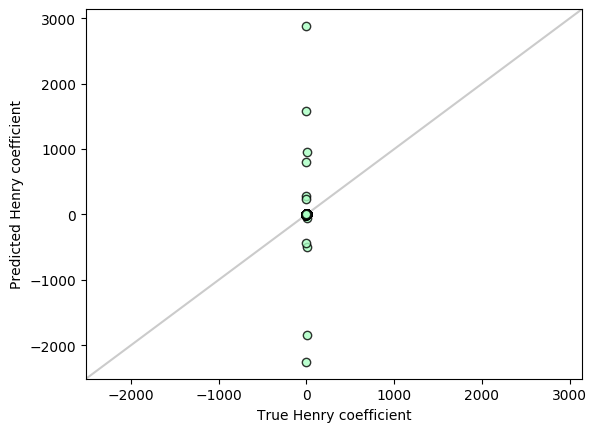

In [60]:
M, G, glrm, ch = fit_glrm(345, 1.0, obs)
Ĥ = impute(glrm)[:]
observed_entries = .! ismissing.(H[:])
fig, ax = plt.subplots()
ax.scatter(H[:][observed_entries], Ĥ[observed_entries], fc="#aaffc3", ec="k", alpha=0.8)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = [min(xlim[1], ylim[1]), max(xlim[2], ylim[2])]
ax.plot(lim, lim, c="#a9a9a9", alpha=0.6, zorder=0.5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel("True Henry coefficient")
ax.set_ylabel("Predicted Henry coefficient")
plt.show()

In [21]:
ks = [1,2,3,4,5]
γs = 10 .^ range(2.0, stop=3.0, length=30);
test_mse = Dict{Int, Array{Float64,1}}(
            k => zeros(length(γs)) for k in ks)

Dict{Int64,Array{Float64,1}} with 5 entries:
  4 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0…
  2 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0…
  3 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0…
  5 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0…
  1 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0…

In [22]:
p = Progress(n_folds * length(ks) * length(γs))

for k in ks
    for (i, γ) in enumerate(γs)
        for (train_fold, test_fold) in kfolds
            M, G, glrm, ch = fit_glrm(k, γ, obs[train_fold])
            Ĥ = impute(glrm)
            H_pred = [Ĥ[_i,_j] for (_i,_j) in obs[test_fold]]
            H_actual = [H[_i,_j] for (_i,_j) in obs[test_fold]]
            test_mse[k][i] += sum((H_actual .- H_pred) .^ 2) / length(test_fold)
            ProgressMeter.next!(p)
        end
        test_mse[k][i] /= length(kfolds)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


In [23]:
test_mse

Dict{Int64,Array{Float64,1}} with 5 entries:
  4 => [1.04519, 0.990371, 1.04333, 0.933873, 0.978001, 0.998631, 0.940693, 0.9…
  2 => [1.10376, 1.00216, 1.02815, 1.04134, 0.95579, 1.02865, 0.920998, 0.95019…
  3 => [1.05841, 1.15496, 1.12943, 1.11978, 1.08526, 1.06129, 0.940332, 1.02579…
  5 => [1.01071, 0.965376, 0.92947, 0.958941, 0.897001, 0.897576, 0.913922, 0.8…
  1 => [0.814047, 0.813642, 0.813642, 0.814047, 0.813528, 0.813642, 0.813768, 0…

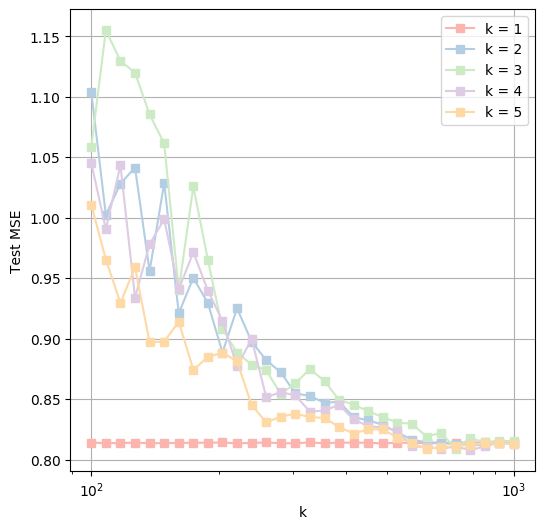

In [24]:
cmap = plt.cm.Pastel1
colors = cmap.colors

fig, ax = plt.subplots(figsize=(6,6))
for (i, _k) in enumerate(ks)
    ax.plot(γs, test_mse[_k], c=colors[i], marker="s", label=@sprintf("k = %d", _k))
end
ax.set_xscale("log")
ax.set_ylabel("Test MSE")
ax.set_xlabel("k")
ax.legend()
ax.grid("on")
plt.show()

In [25]:
min_γ_per_k = [minimum(test_mse[key]) for key in ks]
opt_k = ks[argmin(min_γ_per_k)]
opt_γ = γs[argmin(test_mse[opt_k])]
@printf("Best model has the following parameters:\nk = %d\tγ = %.2e", opt_k, opt_γ)

Best model has the following parameters:
k = 4	γ = 7.88e+02

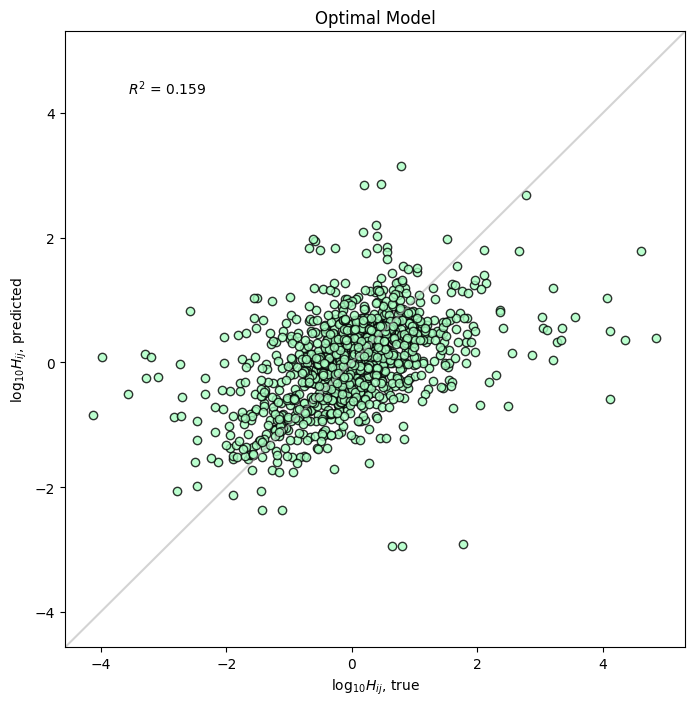

PyObject Text(0.5, 1, 'Optimal Model')

In [26]:
H_actual = []
H_pred = []
for (train_fold, test_fold) in kfolds
    G, M, glrm, ch = fit_glrm(opt_k, opt_γ, obs[train_fold])
    Ĥ = impute(glrm)
    H_actual = vcat(H_actual, [H[i,j] for (i,j) in obs[test_fold]])
    H_pred = vcat(H_pred, [Ĥ[i,j] for (i,j) in obs[test_fold]])
end
R² = 1 - sum((H_actual .- H_pred).^2) / sum((H_actual .- mean(H_actual)).^2)


fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(H_actual[:], H_pred[:], fc="#aaffc3", ec="k", alpha=0.8)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim = [min(xlim[1], ylim[1]), max(xlim[2], ylim[2])]
ax.plot(lim, lim, color="#a9a9a9", alpha=0.5)
ax.text(lim[1]+1, lim[2]-1, @sprintf("\$R^2\$ = %.3f", R²))
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel(L"$\log_{10} H_{ij}$, true")
ax.set_ylabel(L"$\log_{10} H_{ij}$, predicted")

ax.set_title("Optimal Model")